In [1]:
import uproot4 as uproot
print(uproot.__version__)
import numpy as np
import matplotlib.pyplot as plt
# Run this once to install mplhep:
#!pip install mplhep --user 
#!pip install --user awkward1
import mplhep as hep
import pandas as pd
import awkward as ak
#!pip install pyarrow --user
import pyarrow as pa
# Load style sheet
plt.style.use(hep.style.ATLAS)  # or ATLAS/LHCb

import logging

0.1.2


In [2]:
# test_crossDivNrgCrab_35mRad_18x275_v1.xxxx.hcal_clustering.root
# Load a single file and print the branches of the TTree
file = uproot.open("EIC/reconstruction_benchmarks/rec_electron.root")
file.keys()

['events;1', 'metadata;1']

In [3]:
tree = file["events"]
print(tree.num_entries)
branches = tree.keys()
for branch in branches:
    if branch.find("Cluster") != -1:
        print(branch)

1000
CrystalEcalClusters
CrystalEcalClusters/CrystalEcalClusters.energy
CrystalEcalClusters/CrystalEcalClusters.edep
CrystalEcalClusters/CrystalEcalClusters.nhits
CrystalEcalClusters/CrystalEcalClusters.position.x
CrystalEcalClusters/CrystalEcalClusters.position.y
CrystalEcalClusters/CrystalEcalClusters.position.z
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_xx
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_yy
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_zz
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_xy
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_xz
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_yz
CrystalEcalClusters/CrystalEcalClusters.polar.r
CrystalEcalClusters/CrystalEcalClusters.polar.theta
CrystalEcalClusters/CrystalEcalClusters.polar.phi
CrystalEcalClusters/CrystalEcalClusters.cl_theta
CrystalEcalClusters/CrystalEcalClusters.cl_phi
CrystalEcalClusters/CrystalEcalClusters.clusters_begin
CrystalEcalCluste

In [37]:
class HistManager:
    def __init__(self):
        self.histograms = {}
    

    def clear(self):
        self.histograms = {}

    def add(self, df, name, x, cuts=[], nbins=100, range=[0,1], density=False):
        
        
        #branch = df[varString].ravel()
    
        mask = np.ones(len(x), dtype=bool)

        for cut in cuts:
            if len(mask) != len(cut):
                print("Error: existing bitmask and new cut bitmask have different sizes!")

            mask = np.bitwise_and(np.array(mask), np.array(cut))
        
        if name not in self.histograms:
            print(f"Creating histogram named {name} ... ")
            self.histograms[name] = np.histogram(x[mask], nbins, range, density=density)
        else:
            (hist, bins) = np.histogram(x[mask], nbins, range)
            newhist = np.sum([hist, self.histograms[name][0]], axis=0)
            self.histograms[name] = (newhist, self.histograms[name][1])
    
    def get_all(self):
        return self.histograms

    def get(self, name):
        return self.histograms[name]

    def get_hist(self, name):
        return self.histograms[name][0]
    
    def get_bins(self, name):
        return self.histograms[name][1]

def HCALEnergy(row, eta_range=[-1,1]):
    # Primary theta and phi
    primary_theta = row["PrimaryTheta"]
    primary_phi = row["PrimaryPhi"]
    
    primary_eta = -np.log(np.tan(primary_theta/2.0))
    
    if (primary_eta < eta_range[0] or primary_eta > eta_range[1]):
        return -1.0
    
    dRmax = 3.0
    TotalHCAL = 0.0
    
    # Barrrel energies
    try:
        HCALBarrelDeposits = row["HcalBarrelClusters.energy"]
        HCALBarrelTheta = row["HcalBarrelClusters.cl_theta"]
        HCALBarrelPhi = row["HcalBarrelClusters.cl_phi"]
        HCALBarrelDeltaR = np.sqrt( np.power(HCALBarrelTheta - primary_theta,2) + np.power(HCALBarrelPhi - primary_phi, 2))
        TotalHCAL += np.sum(HCALBarrelDeposits[HCALBarrelDeltaR < dRmax])
    except Exception as e:
        #logging.exception(e)
        #print("Unable to retrieve the HcalBarrelClusters information ... !")
        pass
    
    # Endcap energies
    try:
        HCALHadronEndcapDeposits = row["HcalHadronEndcapClusters.energy"]
        HCALHadronEndcapTheta = row["HcalHadronEndcapClusters.cl_theta"]
        HCALHadronEndcapPhi = row["HcalHadronEndcapClusters.cl_phi"]
        HCALHadronEndcapDeltaR = np.sqrt( np.power(HCALHadronEndcapTheta - primary_theta,2) + np.power(HCALHadronEndcapPhi - primary_phi, 2))
        np.sum(HCALHadronEndcapDeposits[HCALHadronEndcapDeltaR < dRmax])
    except:
        #print("Unable to retrieve the HcalHadronEndcapClusters information ... !")
        pass

    try:
        HCALElectronEndcapDeposits = row["HcalElectronEndcapClusters.energy"]
        HCALElectronEndcapTheta = row["HcalElectronEndcapClusters.cl_theta"]
        HCALElectronEndcapPhi = row["HcalElectronEndcapClusters.cl_phi"]
        HCALElectronEndcapDeltaR = np.sqrt( np.power(HCALElectronEndcapTheta - primary_theta,2) + np.power(HCALElectronEndcapPhi - primary_phi, 2))  
        # Sum all backward HCAL clusters w/o matching for now, due to bug in Full Sim cluster eta,phi reporting (2021-06-17)
        #TotalHCAL += np.sum(HCALElectronEndcapDeposits[HCALElectronEndcapDeltaR < dRmax]) 
        TotalHCAL += np.sum(HCALElectronEndcapDeposits)
    except:
        #print("Unable to retrieve the HCalElectronEndcapClusters information ... !")
        pass

        
    return TotalHCAL

def ECALEnergy(row, eta_range=[-1,1]):
    # Primary theta and phi
    primary_theta = row["PrimaryTheta"]
    primary_phi = row["PrimaryPhi"]
    
    primary_eta = -np.log(np.tan(primary_theta/2.0))
    
    if (primary_eta < eta_range[0] or primary_eta > eta_range[1]):
        return -1.0
        
    dRmax = 3.0
    TotalECAL = 0.0
    
    # Barrrel energies
    try:
        ECALBarrelDeposits = row["EcalBarrelClusters.energy"]
        ECALBarrelTheta = row["EcalBarrelClusters.cl_theta"]
        ECALBarrelPhi = row["EcalBarrelClusters.cl_phi"]
        ECALBarrelDeltaR = np.sqrt( np.power(ECALBarrelTheta - primary_theta,2) + np.power(ECALBarrelPhi - primary_phi, 2))
        TotalECAL += np.sum(ECALBarrelDeposits[ECALBarrelDeltaR < dRmax])
    except:
        pass

    # Endcap energies
    try:
        ECALEndcapDeposits = row["EcalEndcapClusters.energy"]
        ECALEndcapTheta = row["EcalEndcapClusters.cl_theta"]
        ECALEndcapPhi = row["EcalEndcapClusters.cl_phi"]
        ECALEndcapDeltaR = np.sqrt( np.power(ECALEndcapTheta - primary_theta,2) + np.power(ECALEndcapPhi - primary_phi, 2))
        TotalECAL += np.sum(ECALEndcapDeposits[ECALEndcapDeltaR < dRmax])
    except:
        pass


    try:
        ECALCrystalDeposits = row["CrystalEcalClusters.energy"]
        ECALCrystalTheta = row["CrystalEcalClusters.cl_theta"]
        ECALCrystalPhi = row["CrystalEcalClusters.cl_phi"]
        ECALCrystalDeltaR = np.sqrt( np.power(ECALCrystalTheta - primary_theta,2) + np.power(ECALCrystalPhi - primary_phi, 2))
        TotalECAL += np.sum(ECALCrystalDeposits[ECALCrystalDeltaR < dRmax])
    except:
        pass

    
    return TotalECAL


def PrimaryTrackTheta(row):
    mc_ID = row["mcparticles2.pdgID"]
    mc_status = row["mcparticles2.genStatus"]
    mc_vx = row["mcparticles2.psx"]
    mc_vy = row["mcparticles2.psy"]
    mc_vz = row["mcparticles2.psz"]
    
    isThrown = mc_status == 1
    thrown_ID = mc_ID[isThrown]
    theta = np.arctan2(np.sqrt(mc_vx[isThrown]**2 + mc_vy[isThrown]**2), mc_vz[isThrown])
    phi = np.arctan2(mc_vy[isThrown],mc_vx[isThrown])
    
    
    return theta[0]

def PrimaryTrackPhi(row):
    mc_ID = row["mcparticles2.pdgID"]
    mc_status = row["mcparticles2.genStatus"]
    mc_vx = row["mcparticles2.psx"]
    mc_vy = row["mcparticles2.psy"]
    mc_vz = row["mcparticles2.psz"]
    
    isThrown = mc_status == 1
    thrown_ID = mc_ID[isThrown]
    theta = np.arctan2(np.sqrt(mc_vx[isThrown]**2 + mc_vy[isThrown]**2), mc_vz[isThrown])
    phi = np.arctan2(mc_vy[isThrown],mc_vx[isThrown])
    
    return phi[0]

def PrimaryTrackID(row):
    mc_ID = row["mcparticles2.pdgID"]
    mc_status = row["mcparticles2.genStatus"]
    
    isThrown = mc_status == 1
    thrown_ID = mc_ID[isThrown]
    
    return thrown_ID[0]


def ProcessFiles(files={}, branches=[], hist_manager=None, name="", eta_range=[-1,1], output_arrays = None):
    count = 0
    for batch in uproot.iterate([files], 
                            branches, 
                            step_size = '1000 MB',
                            library="np"):

        df = pd.DataFrame(batch)
        df["PrimaryID"]     = df.apply(PrimaryTrackID, axis=1)
        df["PrimaryTheta"]  = df.apply(PrimaryTrackTheta, axis=1)
        df["PrimaryPhi"]    = df.apply(PrimaryTrackPhi,  axis=1)
        #df["ECALEnergyFraction"] = df.apply(ECALEnergyFraction, axis=1)
        df["ECALEnergy"] = df.apply(ECALEnergy, eta_range=eta_range, axis=1)
        df["HCALEnergy"] = df.apply(HCALEnergy, eta_range=eta_range, axis=1)
        df["ECALEnergyFraction"] = df["ECALEnergy"]/(df["ECALEnergy"] + df["HCALEnergy"])
        
        #if count < 1:
            # print(df)
            # print(df.apply(PrimaryTrackMomentum, axis=1))
        
#         if count < 1:
#             print(df[["ECALEnergyFraction", "PrimaryTheta", "PrimaryPhi"]])
            
        hist_manager.add(df, f"{name}ECALEnergyFraction", x=df["ECALEnergyFraction"], cuts=[(df["ECALEnergy"] + df["HCALEnergy"]) > 0], nbins=100, range=[0,1.0], density=True)
        hist_manager.add(df, f"{name}ECALEnergy", x=df["ECALEnergy"]/1000.0, cuts=[], nbins=100, range=[0,10.0], density=True)
        hist_manager.add(df, f"{name}HCALEnergy", x=df["HCALEnergy"]/1000.0, cuts=[], nbins=100, range=[0,10.0], density=True)
        count += 1
        
        if output_arrays is not None:
            for key in output_arrays:
                output_arrays[key] = np.concatenate([output_arrays[key], df[key]])
        


# Barrel Study

This part focuses on electrons and pions at 5 GeV/c fired into the barrel region, $\eta=[-1,1]$.

In [43]:
e_files = {"EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_electron_1k-[0-9].root": "events", 
          "EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_electron_1k-[0-4][0-9].root": "events"}
pi_files = {"EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_pion+_1k-[0-9].root": "events",
           "EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_pion+_1k-[0-4][0-9].root": "events"}
branches = ['EcalBarrelClusters.energy', 'HcalBarrelClusters.energy',
            'EcalEndcapClusters.energy', 'HcalHadronEndcapClusters.energy', 'HcalElectronEndcapClusters.energy', 'CrystalEcalClusters.energy',
            'EcalBarrelClusters.cl_theta', 'HcalBarrelClusters.cl_theta',
            'EcalEndcapClusters.cl_theta', 'HcalHadronEndcapClusters.cl_theta', 'HcalElectronEndcapClusters.cl_theta', 'CrystalEcalClusters.cl_theta',
            'EcalBarrelClusters.cl_phi', 'HcalBarrelClusters.cl_phi',
            'EcalEndcapClusters.cl_phi', 'HcalHadronEndcapClusters.cl_phi', 'HcalElectronEndcapClusters.cl_phi', 'CrystalEcalClusters.cl_phi',
            'mcparticles2.pdgID', 'mcparticles2.genStatus',
            'mcparticles2.psx', 'mcparticles2.psy', 'mcparticles2.psz']

hm = HistManager()
hm.clear()

data_arrays = {}
data_arrays["PrimaryID"] = np.array([])
data_arrays["ECALEnergyFraction"] = np.array([])
data_arrays["ECALEnergy"] = np.array([])
data_arrays["HCALEnergy"] = np.array([])

ProcessFiles(e_files, branches, hm, "e", eta_range=[-1,1], output_arrays=data_arrays)
ProcessFiles(pi_files, branches, hm, "pi", eta_range=[-1,1], output_arrays=data_arrays)

Creating histogram named eECALEnergyFraction ... 
Creating histogram named eECALEnergy ... 
Creating histogram named eHCALEnergy ... 
Creating histogram named piECALEnergyFraction ... 
Creating histogram named piECALEnergy ... 
Creating histogram named piHCALEnergy ... 
    PrimaryID  ECALEnergyFraction   ECALEnergy  HCALEnergy
0        11.0                 1.0   150.653279         0.0
1        11.0                 1.0  5481.594037         0.0
4        11.0                 1.0  5126.877690         0.0
5        11.0                 1.0     4.794758         0.0
10       11.0                 1.0  3584.145514         0.0


In [44]:
# Save the results of the file processing to a new dataframe for saving to disk
df = pd.DataFrame( data_arrays, columns = ['PrimaryID', 'ECALEnergyFraction', 'ECALEnergy', 'HCALEnergy'])
df = df[df["ECALEnergy"] + df["HCALEnergy"] > 0.0]
print(df.head())


    PrimaryID  ECALEnergyFraction   ECALEnergy  HCALEnergy
0        11.0                 1.0   150.653279         0.0
1        11.0                 1.0  5481.594037         0.0
4        11.0                 1.0  5126.877690         0.0
5        11.0                 1.0     4.794758         0.0
10       11.0                 1.0  3584.145514         0.0


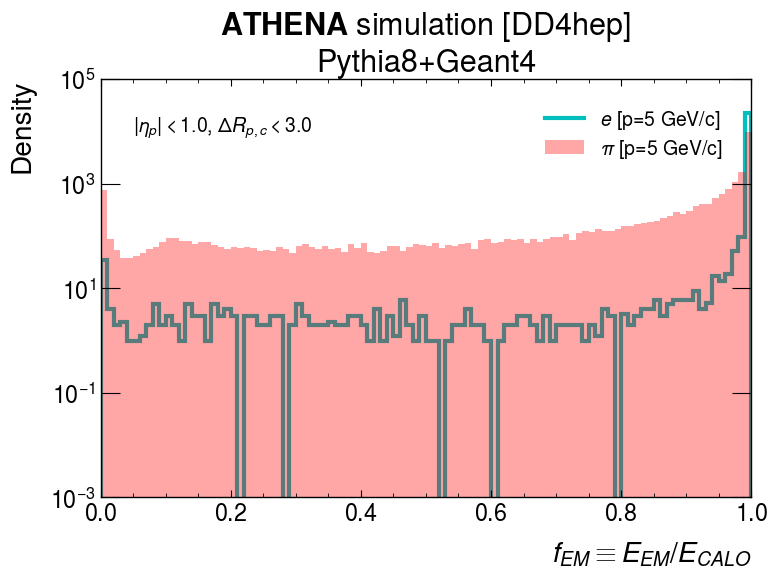

In [9]:
hep.histplot(hm.get_hist("eECALEnergyFraction"), hm.get_bins("eECALEnergyFraction"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergyFraction"), hm.get_bins("piECALEnergyFraction"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$f_{EM} \equiv E_{EM}/E_{CALO}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.05,1e4,"$|\eta_p| < 1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMFraction_e_vs_pi-G4.png", dpi=200)

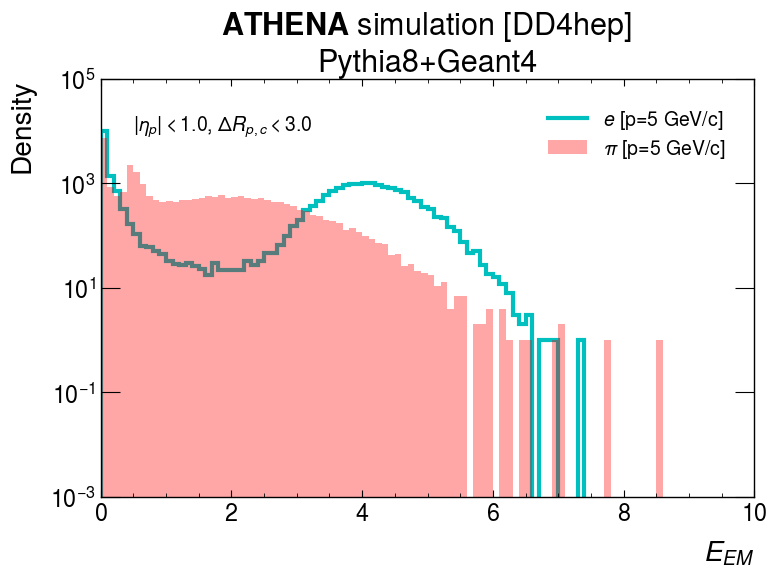

In [10]:
hep.histplot(hm.get_hist("eECALEnergy"), hm.get_bins("eECALEnergy"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergy"), hm.get_bins("piECALEnergy"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{EM}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e4,"$|\eta_p| < 1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMEnergy_e_vs_pi-G4.png", dpi=200)

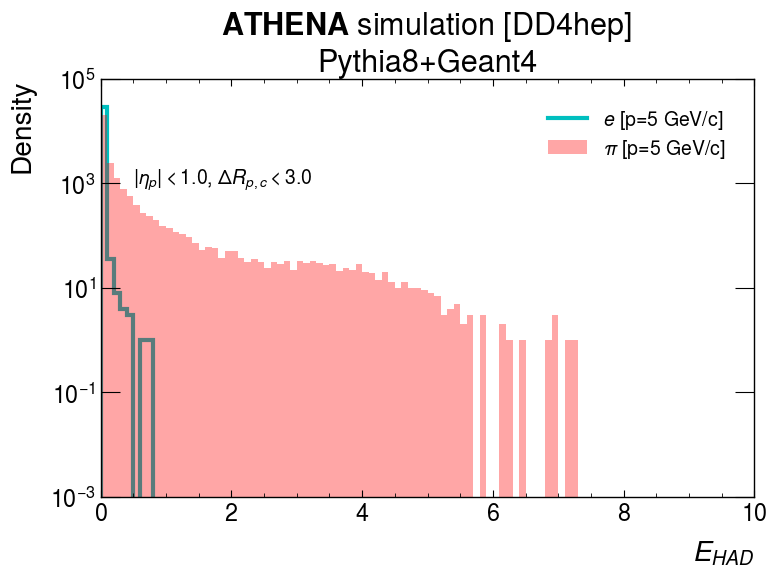

In [11]:
hep.histplot(hm.get_hist("eHCALEnergy"), hm.get_bins("eHCALEnergy"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piHCALEnergy"), hm.get_bins("piHCALEnergy"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{HAD}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1000,"$|\eta_p| < 1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("HADEnergy_e_vs_pi-G4.png", dpi=200)

# Backward Endcap Study

The samples below focus only on the backward endcap, the Crystal ECAL and the electron-side HCAL. Electrons and pions are only being generated at 5 GeV momentum and for angles from 90- to 175- degrees. I will focus on $\eta=[-3,-1]$.

In [251]:
# Load a single file and print the branches of the TTree
file = uproot.open("EIC/reconstruction_benchmarks/rec_electron_1k-0.root")
tree = file["events"]
branches = tree.keys()
for branch in branches:
    if branch.find("Cluster") != -1:
        print(branch)

1000
CrystalEcalClusters
CrystalEcalClusters/CrystalEcalClusters.energy
CrystalEcalClusters/CrystalEcalClusters.edep
CrystalEcalClusters/CrystalEcalClusters.nhits
CrystalEcalClusters/CrystalEcalClusters.position.x
CrystalEcalClusters/CrystalEcalClusters.position.y
CrystalEcalClusters/CrystalEcalClusters.position.z
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_xx
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_yy
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_zz
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_xy
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_xz
CrystalEcalClusters/CrystalEcalClusters.positionError.cov_yz
CrystalEcalClusters/CrystalEcalClusters.polar.r
CrystalEcalClusters/CrystalEcalClusters.polar.theta
CrystalEcalClusters/CrystalEcalClusters.polar.phi
CrystalEcalClusters/CrystalEcalClusters.cl_theta
CrystalEcalClusters/CrystalEcalClusters.cl_phi
CrystalEcalClusters/CrystalEcalClusters.clusters_begin
CrystalEcalCluste

In [15]:
e_files = {"EIC/reconstruction_benchmarks/rec_electron_1k-[0-9].root": "events", 
          "EIC/reconstruction_benchmarks/rec_electron_1k-[1-4][0-9].root": "events"}
pi_files = {"EIC/reconstruction_benchmarks/rec_pion+_1k-[0-9].root": "events",
           "EIC/reconstruction_benchmarks/rec_pion+_1k-[1-4][0-9].root": "events"}

branches = ['EcalBarrelClusters.energy', 
            'EcalEndcapClusters.energy', 'HcalHadronEndcapClusters.energy', 'HcalElectronEndcapClusters.energy', 'CrystalEcalClusters.energy',
            'EcalBarrelClusters.cl_theta', 
            'EcalEndcapClusters.cl_theta', 'HcalHadronEndcapClusters.cl_theta', 'HcalElectronEndcapClusters.cl_theta', 'CrystalEcalClusters.cl_theta',
            'EcalBarrelClusters.cl_phi', 
            'EcalEndcapClusters.cl_phi', 'HcalHadronEndcapClusters.cl_phi', 'HcalElectronEndcapClusters.cl_phi', 'CrystalEcalClusters.cl_phi',
            'mcparticles2.pdgID', 'mcparticles2.genStatus',
            'mcparticles2.psx', 'mcparticles2.psy', 'mcparticles2.psz']

hm = HistManager()
hm.clear()

ProcessFiles(e_files, branches, hm, "e",  eta_range=[-3,-1])
ProcessFiles(pi_files, branches, hm, "pi", eta_range=[-3,-1])

Creating histogram named eECALEnergyFraction ... 
Creating histogram named eECALEnergy ... 
Creating histogram named eHCALEnergy ... 
Creating histogram named piECALEnergyFraction ... 
Creating histogram named piECALEnergy ... 
Creating histogram named piHCALEnergy ... 


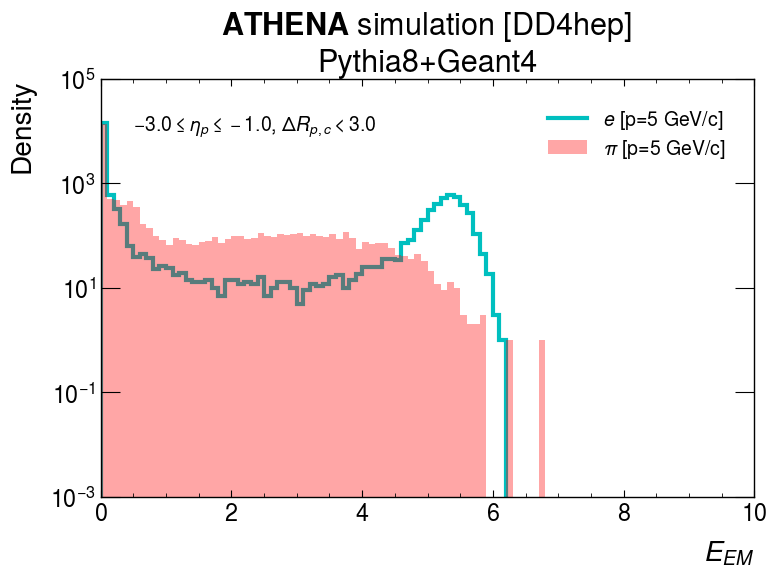

In [16]:
hep.histplot(hm.get_hist("eECALEnergy"), hm.get_bins("eECALEnergy"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergy"), hm.get_bins("piECALEnergy"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{EM}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e4,r"$-3.0 \leq \eta_p \leq -1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMEnergy_e_vs_pi-eta_-30_-10-G4.png", dpi=200)

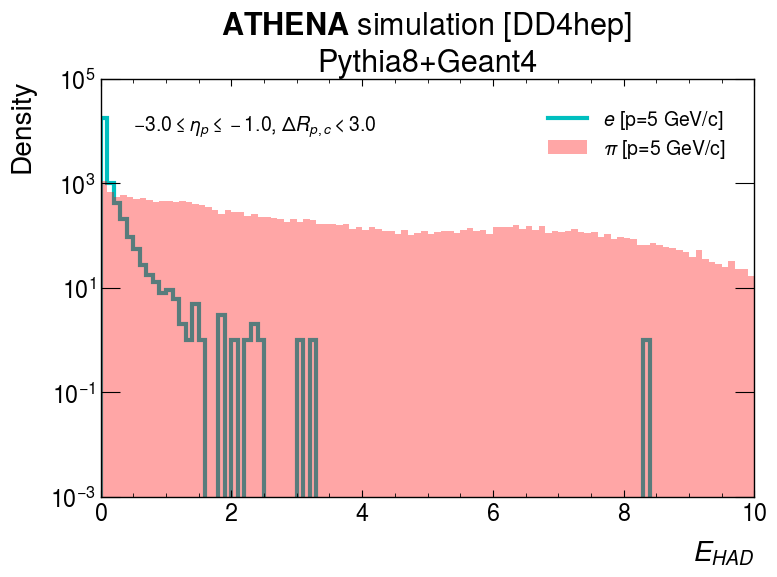

In [17]:
hep.histplot(hm.get_hist("eHCALEnergy"), hm.get_bins("eHCALEnergy"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piHCALEnergy"), hm.get_bins("piHCALEnergy"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{HAD}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e4,r"$-3.0 \leq \eta_p \leq -1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("HADEnergy_e_vs_pi-eta_-30_-10-G4.png", dpi=200)

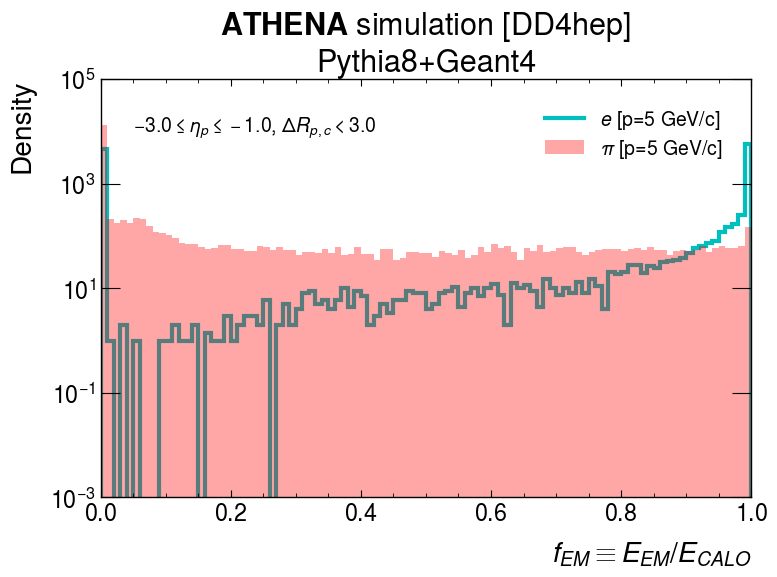

In [18]:
hep.histplot(hm.get_hist("eECALEnergyFraction"), hm.get_bins("eECALEnergyFraction"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergyFraction"), hm.get_bins("piECALEnergyFraction"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$f_{EM} \equiv E_{EM}/E_{CALO}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.05,1e4,r"$-3.0 \leq \eta_p \leq -1.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMFraction_e_vs_pi-eta_-30_-10-G4.png", dpi=200)

# Forward Endcap Study

This part focuses on electrons and pions at 5 GeV/c fired into the forward endcap region, $\eta=[1,3]$.

In [3]:
e_files = {"EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_electron_1k-[0-9].root": "events", 
          "EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_electron_1k-[0-4][0-9].root": "events"}
pi_files = {"EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_pion+_1k-[0-9].root": "events",
           "EIC/reconstruction_benchmarks/2021-06-17-NoHcalElectronEndcap/rec_pion+_1k-[0-4][0-9].root": "events"}
branches = ['EcalBarrelClusters.energy', 'HcalBarrelClusters.energy',
            'EcalEndcapClusters.energy', 'HcalHadronEndcapClusters.energy', 'HcalElectronEndcapClusters.energy', 'CrystalEcalClusters.energy',
            'EcalBarrelClusters.cl_theta', 'HcalBarrelClusters.cl_theta',
            'EcalEndcapClusters.cl_theta', 'HcalHadronEndcapClusters.cl_theta', 'HcalElectronEndcapClusters.cl_theta', 'CrystalEcalClusters.cl_theta',
            'EcalBarrelClusters.cl_phi', 'HcalBarrelClusters.cl_phi',
            'EcalEndcapClusters.cl_phi', 'HcalHadronEndcapClusters.cl_phi', 'HcalElectronEndcapClusters.cl_phi', 'CrystalEcalClusters.cl_phi',
            'mcparticles2.pdgID', 'mcparticles2.genStatus',
            'mcparticles2.psx', 'mcparticles2.psy', 'mcparticles2.psz']

hm = HistManager()
hm.clear()

ProcessFiles(e_files, branches, hm, "e", eta_range=[1,3])
ProcessFiles(pi_files, branches, hm, "pi", eta_range=[1,3])

Creating histogram named eECALEnergyFraction ... 
Creating histogram named eECALEnergy ... 
Creating histogram named eHCALEnergy ... 
Creating histogram named piECALEnergyFraction ... 
Creating histogram named piECALEnergy ... 
Creating histogram named piHCALEnergy ... 


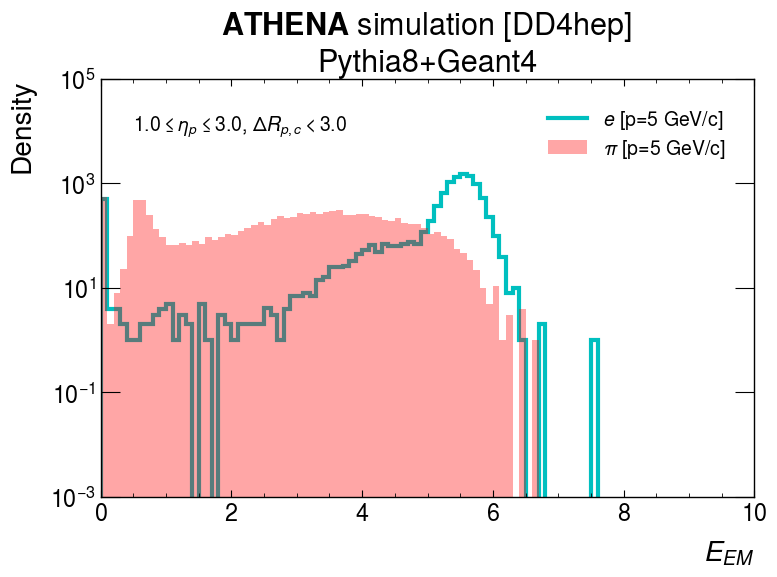

In [4]:
hep.histplot(hm.get_hist("eECALEnergy"), hm.get_bins("eECALEnergy"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergy"), hm.get_bins("piECALEnergy"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{EM}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e4,r"$1.0 \leq \eta_p \leq 3.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMEnergy_e_vs_pi-eta_10_30-G4.png", dpi=200)

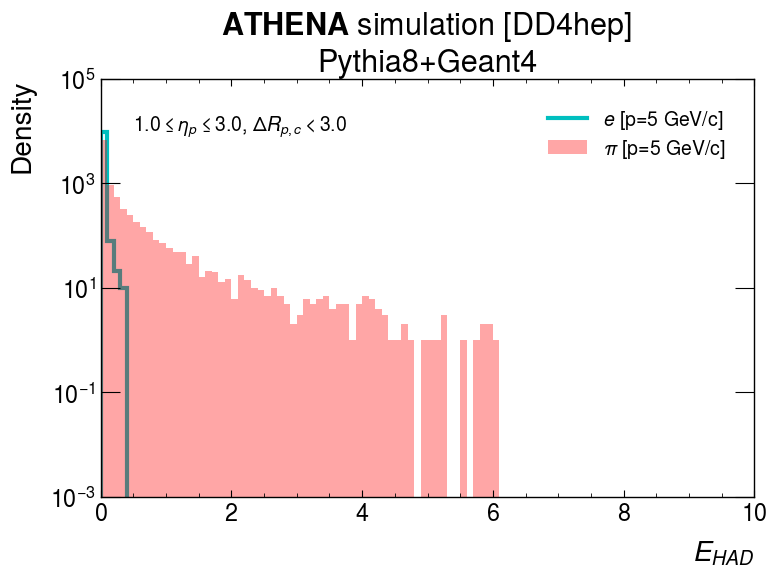

In [5]:
hep.histplot(hm.get_hist("eHCALEnergy"), hm.get_bins("eHCALEnergy"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piHCALEnergy"), hm.get_bins("piHCALEnergy"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$E_{HAD}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.5,1e4,r"$1.0 \leq \eta_p \leq 3.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("HADEnergy_e_vs_pi-eta_10_30-G4.png", dpi=200)

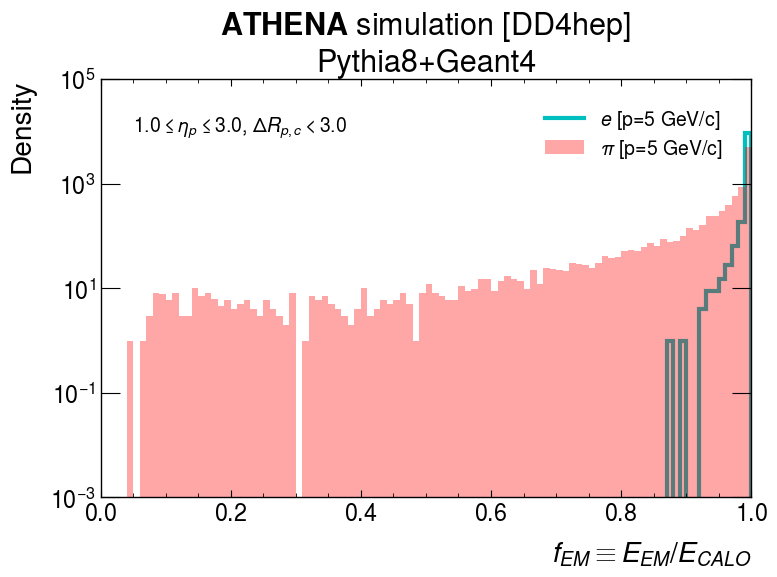

In [6]:
hep.histplot(hm.get_hist("eECALEnergyFraction"), hm.get_bins("eECALEnergyFraction"), label="$e$ [p=5 GeV/c]", alpha=1.0, color='c', fill=False, lw=3)
hep.histplot(hm.get_hist("piECALEnergyFraction"), hm.get_bins("piECALEnergyFraction"), label="$\pi$ [p=5 GeV/c]",alpha=0.35, color='r', fill=True)
#plt.title("DD4HEP/GEANT4 Single-Particle Events")
plt.title(r"$\bf{ATHENA}$" +' simulation [DD4hep] \nPythia8+Geant4',fontsize=22)
plt.xlabel("$f_{EM} \equiv E_{EM}/E_{CALO}$")
plt.ylabel("Density")
plt.legend()
plt.ylim([1e-3,1e5])
plt.yscale("log")
# plt.xscale("log")
plt.text(0.05,1e4,r"$1.0 \leq \eta_p \leq 3.0$, $\Delta R_{p,c} < 3.0$")
plt.tight_layout()
plt.savefig("EMFraction_e_vs_pi-eta_10_30-G4.png", dpi=200)

In [ ]:
# Save Information to a New ROOT File

In [45]:
import uproot3 as uproot3
output_file = uproot3.recreate("Electron_PID_CALO_Study.root")
output_file["tree"] = uproot3.newtree({"ECALEnergyFraction": np.float64,
                                       "ECALEnergy": np.float64,
                                       "HCALEnergy": np.float64,
                                       "PrimaryID": int})
output_file["tree"].extend({"PrimaryID": df['PrimaryID'],
                           'ECALEnergyFraction': df['ECALEnergyFraction'],
                           'ECALEnergy': df['ECALEnergy'], 
                           'HCALEnergy':df['HCALEnergy']})